# Ví dụ 1.  
Phân loại dữ liệu tự tạo

## Tạo dữ liệu  
3 class, 2D sao cho không thể dùng phân loại tuyến tính  

In [1]:
# import the necessary libraries
from __future__ import division, print_function, unicode_literals
import math
import numpy as np
import matplotlib.pyplot as plt

N = 200  # number of points per class
d = 2  # dimensionality
C = 3  # number of classes
X = np.zeros((d, N * C))  # data matrix (each row = single example)
y = np.zeros(N * C, dtype="uint8")  # class labels

for j in range(C):
    ix = range(N * j, N * (j + 1))
    r = np.linspace(0.0, 1, N)  # radius
    t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2  # theta: + 1 đại lượng random để đảm vảo phân bố ngẫu nhiên của điểm dữ liệu
    X[:, ix] = np.c_[r * np.sin(t), r * np.cos(t)].T
    y[ix] = j

## Trực quan hóa dữ liệu

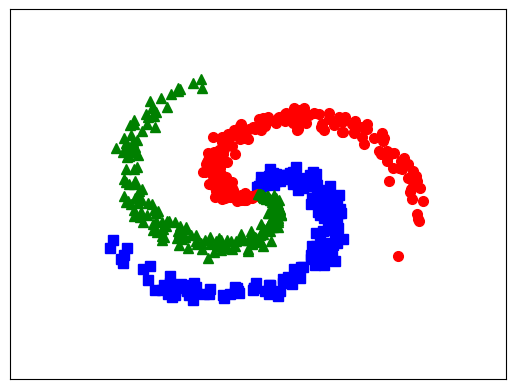

In [2]:
# lets visualize the data:
plt.plot(X[0, :N], X[1, :N], "bs", markersize=7)
plt.plot(X[0, N : 2 * N], X[1, N : 2 * N], "ro", markersize=7)
plt.plot(X[0, 2 * N :], X[1, 2 * N :], "g^", markersize=7)

plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])

# plt.savefig("example1_points.png", bbox_inches="tight", dpi=600)
plt.show()

## Code mô hình ANN không sử dụng thư viện  

### Xây dựng softmax, cost, one-hot coding  

In [3]:
# output layer to value in [0, 1]
def softmax(V):
    e_V = np.exp(V - np.max(V, axis=0, keepdims=True))
    Z = e_V / e_V.sum(axis=0)
    return Z


# cost or loss function
def cost(Y, Yhat):
    return -np.sum(Y * np.log(Yhat)) / Y.shape[1]


# make one-hot coding
from scipy import sparse
def convert_labels(y, C=3):
    Y = sparse.coo_matrix(
        (np.ones_like(y), (y, np.arange(len(y)))), shape=(C, len(y))
    ).toarray()
    return Y

### Xây dựng kiến trúc mạng  
Bổ sung 01 tầng hidden với số units của tầng này là 100 (có thể thay đổi cho phù hợp với đặc điểm của dữ liệu).  
Layer output là 1 vector 3 thành phần cho 3 nhãn đầu ra.  
Như vậy các tầng trong ANN này là:  
 - Tầng input: d0 = 2
 - Tầng hidden: d1 = 100
 - Tầng output: d2 = 3 

In [11]:
def build_ANN(X, y):
    d0 = 2 
    d1 = h = 100 # size of hidden layer 
    d2 = C = 3 
    # initialize parameters randomly 
    W1 = 0.01*np.random.randn(d0, d1) 
    b1 = np.zeros((d1, 1)) 
    W2 = 0.01*np.random.randn(d1, d2) 
    b2 = np.zeros((d2, 1)) 
    # set data
    Y = convert_labels(y, C) 
    N = X.shape[1] 
    eta = 1 # learning rate
    # bước lặp tìm cực trị theo Gradient Descent 
    for i in range(10000): 
        ## Feedforward 
        Z1 = np.dot(W1.T, X) + b1 
        A1 = np.maximum(Z1, 0) 
        Z2 = np.dot(W2.T, A1) + b2 
        Yhat = softmax(Z2) 
    
        # print loss after each 1000 iterations 
        if i %1000 == 0: 
            # compute the loss: average cross-entropy loss 
            loss = cost(Y, Yhat) 
            print("iter %d, loss: %f" %(i, loss)) 
    
        # backpropagation 
        E2 = (Yhat - Y )/N 
        dW2 = np.dot(A1, E2.T) 
        db2 = np.sum(E2, axis = 1, keepdims = True) 
        E1 = np.dot(W2, E2) 
        E1[Z1 <= 0] = 0 # gradient of ReLU 
        dW1 = np.dot(X, E1.T) 
        db1 = np.sum(E1, axis = 1, keepdims = True)

        # Gradient Descent update 
        W1 += -eta*dW1 
        b1 += -eta*db1 
        W2 += -eta*dW2 
        b2 += -eta*db2

    # return ANN
    return (W1, W2, b1, b2, d0, d1, d2)

def run_ANN(model, X):
    # W1, W2, b1, b2 is ANN
    # X is input & y is output
    # this function return predicted class 
    W1, W2, b1, b2 = model[0], model[1], model[2], model[3]
    Z1 = np.dot(W1.T, X) + b1 
    A1 = np.maximum(Z1, 0) 
    Z2 = np.dot(W2.T, A1) + b2 
    predicted_class = np.argmax(Z2, axis=0)
    return predicted_class

### Thực hiện chạy hàm xây dựng ANN và xác định Accuracy  

In [12]:
model = build_ANN(X, y)
predicted_class = run_ANN(model=model, X=X)
acc = 100*np.mean(predicted_class == y) 
print('training accuracy: %.2f %%' % (acc)) 

iter 0, loss: 1.098630
iter 1000, loss: 0.139456
iter 2000, loss: 0.045205
iter 3000, loss: 0.030869
iter 4000, loss: 0.025280
iter 5000, loss: 0.022114
iter 6000, loss: 0.020025
iter 7000, loss: 0.018516
iter 8000, loss: 0.017357
iter 9000, loss: 0.016437
training accuracy: 99.67 %


### Trực quan hóa mô hình train được  

In [17]:
def visualize_ANN(model=model):
    W1, W2, b1, b2, d1 = model[0], model[1], model[2], model[3], model[5]
    # Visualize results
    xm = np.arange(-1.5, 1.5, 0.025)
    xlen = len(xm)
    ym = np.arange(-1.5, 1.5, 0.025)
    ylen = len(ym)
    xx, yy = np.meshgrid(xm, ym)

    # xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # xx.ravel(), yy.ravel()

    print(np.ones((1, xx.size)).shape)
    xx1 = xx.ravel().reshape(1, xx.size)
    yy1 = yy.ravel().reshape(1, yy.size)

    # print(xx.shape, yy.shape)
    # XX = np.concatenate((np.ones((1, xx.size)), xx1, yy1), axis = 0)

    X0 = np.vstack((xx1, yy1))

    # print(X.shape)

    Z1 = np.dot(W1.T, X0) + b1
    A1 = np.maximum(Z1, 0)
    Z2 = np.dot(W2.T, A1) + b2
    # predicted class
    Z = np.argmax(Z2, axis=0)

    Z = Z.reshape(xx.shape)
    CS = plt.contourf(xx, yy, Z, 200, cmap="jet", alpha=0.1)

    # Plot also the training points
    # plt.scatter(X[:, 1], X[:, 2], c=Y, edgecolors='k', cmap=plt.cm.Paired)
    # plt.xlabel('Sepal length')
    # plt.ylabel('Sepal width')

    # X = X.T
    N = 200
    print(N)

    plt.plot(X[0, :N], X[1, :N], "bs", markersize=7)
    plt.plot(X[0, N : 2 * N], X[1, N : 2 * N], "ro", markersize=7)
    plt.plot(X[0, 2 * N :], X[1, 2 * N :], "g^", markersize=7)
    # plt.axis('off')
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_ticks([])
    cur_axes.axes.get_yaxis().set_ticks([])

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.xticks(())
    plt.yticks(())
    plt.title("#hidden units = %d, accuracy = %.2f %%" % (d1, acc))
    # plt.axis('equal')
    # display(X[1:, :], original_label)
    fn = "ex_res" + str(d1) + ".png"
    # plt.savefig(fn, bbox_inches='tight', dpi = 600)
    plt.show()

(1, 14400)
200


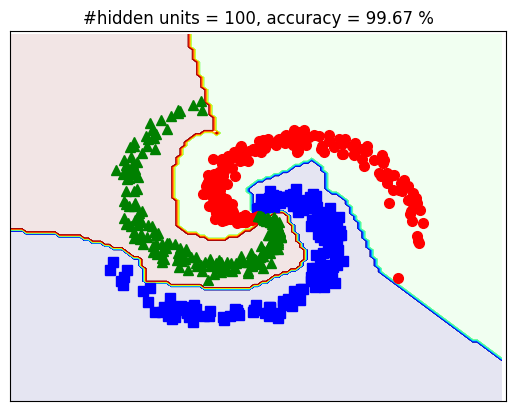

In [18]:
visualize_ANN(model=model)

# Bài tập ứng dụng 1.  
Sử dụng ANN cho bài toán phân loại dữ liệu hoa Iris

## Đọc vào dữ liệu hoa Iris  

In [1]:
import pandas as pd 
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load the Iris dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Huấn luyện ANN cho bài toán phân loại hoa Iris

In [7]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the ANN model
model = Sequential()
model.add(Dense(4, activation='relu'))  # input has 4 dimension
model.add(Dense(4, activation='relu'))  # 8 neutrons may be good
# model.add(Dense(8, activation='relu'))  # 8 neutrons may be good
# after 2 times try then 4 neutrons in only 1 hidden class give better accuracy
model.add(Dense(3, activation='softmax'))   # output has 3 classes

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0)
# verbose = 0 to remove cell output as too many output lines
epoch_1_accuracy = history.history['accuracy'][0]
epoch_1_val_accuracy = history.history['val_accuracy'][0]
epoch_100_accuracy = history.history['accuracy'][-1]
epoch_100_val_accuracy = history.history['val_accuracy'][-1]

print("Epoch 1 - Accuracy:", epoch_1_accuracy, "Validation Accuracy:", epoch_1_val_accuracy)
print("Epoch 100 - Accuracy:", epoch_100_accuracy, "Validation Accuracy:", epoch_100_val_accuracy)


Epoch 1 - Accuracy: 0.35185185074806213 Validation Accuracy: 0.3333333432674408
Epoch 100 - Accuracy: 0.8518518805503845 Validation Accuracy: 0.75


## Thử nghiệm và xác định Accuracy

In [8]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

Test accuracy: 0.800000011920929
Test loss: 0.5758970379829407


# Ví dụ 2.  
Sử dụng Multinomial Logistic Regression và ANN để phân loại dữ liệu chữ số viết tay  

## Đọc dữ liệu chữ viết tay

Xác định đường dẫn đến dữ liệu

In [14]:
import os
import numpy as np
# set names to the paths because they're too long
data_path = 'data/number_writing'
# train path
train_images_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')
# test path
test_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')

Hàm đọc dữ liệu từ tệp nén gzip và chuyển thành ma trận số (ảnh)

In [15]:
def get_mnist_data(images_path, labels_path, num_images, shuffle=False, _is=True, image_size=28):
    """
    This shuffle param is active when .gz is downloaded at:
    - 'http://yann.lecun.com/exdb/mnist/'
    - This function return random num_images in 60000 or 10000
    """
    # read data
    import gzip
    # to decompress gz (zip) file
    # open file training to read training data
    f_images = gzip.open(images_path,'r')
    # skip 16 first bytes because these are not data, only header infor
    f_images.read(16)
    # general: read num_images data samples if this parameter is set;
    # if not, read all (60000 training or 10000 test)
    real_num = num_images if not shuffle else (60000 if _is else 10000)
    # read all data to buf_images (28x28xreal_num)
    buf_images = f_images.read(image_size * image_size * real_num)
    # images
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size,)
    # Read labels
    f_labels = gzip.open(labels_path,'r')
    f_labels.read(8)
    labels = np.zeros((real_num)).astype(np.int64)
    # rearrange to correspond the images and labels
    for i in range(0, real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)
    # shuffle to get random images data
    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)
        images = images[rand_id, :]
        labels = labels[rand_id,]
    # change images data to type of vector 28x28 dimentional
    images = images.reshape(num_images, image_size * image_size)
    return images, labels

Sử dụng hàm xây dựng bên trên tạo bộ train 5000 ảnh và bộ test 10000 ảnh

In [16]:
train_images, train_labels = get_mnist_data(train_images_path, train_labels_path, 5000, shuffle=True)
test_images, test_labels = get_mnist_data(test_images_path, test_labels_path, 10000, _is=False, shuffle=True)
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

/tmp/ipykernel_7263/1956505741.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)


(5000, 784) (5000,)
(10000, 784) (10000,)


## Xây dựng và huấn luyện mô hình

### Sử dụng Multinomial Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Khởi tạo mô hình Logistic Regression
mlr_model = LogisticRegression(multi_class='multinomial', max_iter=10000)

# Huấn luyện mô hình trên dữ liệu huấn luyện
mlr_model.fit(train_images, train_labels)


LogisticRegression(max_iter=10000, multi_class='multinomial')

### Sử dụng ANN

In [22]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(train_images)
test_images_scaled = scaler.transform(test_images)

# Build the ANN model
ann_model = Sequential()
ann_model.add(Dense(784, activation='relu'))  # input has 784 dimension
ann_model.add(Dense(784, activation='relu'))  # maybe 784 is good
ann_model.add(Dense(10, activation='softmax'))   # output has 10 classes

# Compile the model
ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = ann_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0)
# verbose = 0 to remove cell output as too many output lines
epoch_1_accuracy = history.history['accuracy'][0]
epoch_1_val_accuracy = history.history['val_accuracy'][0]
epoch_100_accuracy = history.history['accuracy'][-1]
epoch_100_val_accuracy = history.history['val_accuracy'][-1]

print("Epoch 1 - Accuracy:", epoch_1_accuracy, "Validation Accuracy:", epoch_1_val_accuracy)
print("Epoch 100 - Accuracy:", epoch_100_accuracy, "Validation Accuracy:", epoch_100_val_accuracy)

Epoch 1 - Accuracy: 0.6481481194496155 Validation Accuracy: 0.6666666865348816
Epoch 100 - Accuracy: 1.0 Validation Accuracy: 1.0


## Thử nghiệm và xác định accuracy

In [20]:
# Dự đoán nhãn cho dữ liệu test
mlr_y_pred = mlr_model.predict(test_images)

# Tính toán độ chính xác trên tập test
mlr_accuracy = accuracy_score(test_labels, mlr_y_pred)
print("Accuracy on test set for multinomial logistic regression:", mlr_accuracy)

Accuracy on test set for multinomial logistic regression: 0.8762


In [23]:
# Evaluate the model on the test set
ann_test_loss, ann_test_acc = ann_model.evaluate(X_test_scaled, y_test, verbose=0)
print('Test accuracy of ANN:', ann_test_acc)
print('Test loss of ANN:', ann_test_loss)

Test accuracy of ANN: 0.9333333373069763
Test loss of ANN: 0.21252845227718353


# Ví dụ 3.  
(Bài tập nộp ngay trên lớp)  
Sử dụng Multinomial Logistic Regression, Naive Bayes, ANN để phân loại dữ liệu khuôn mặt  

## Thông tin về bộ dữ liệu  

Bộ dữ liệu gồm 165 ảnh của 15 người. Mỗi người chụp ở 11 trạng thái khác nhau lưu dưới dạng tệp .png.  
  
Tên ảnh được ghép bởi:  
 - prefix 'subject', chỉ số của người tương ứng ghi theo kiểu 01, 02 ... đến 15 và dấu chấm “.” .  
 - Tiếp theo là  các trạng thái, gồm 11 trạng thái ['centerlight', 'glasses', 'happy', 'leftlight',  'noglasses', 'normal', 'rightlight', 'sad', 'sleepy', 'surprised', 'wink']  
 - Cuối cùng là phần mở rộng trong tên tệp, .png.

## Đọc dữ liệu và tiền xử lý  
Đọc ảnh -> Lấy ma trận điểm ảnh -> Duỗi thẳng thành vector với số chiều D = height * width

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import cv2


def read_data(path, prefix="subject", surfix=".png"):
    ids = range(1, 16)  # 15 people
    states = [
        "centerlight",
        "glasses",
        "happy",
        "leftlight",
        "noglasses",
        "normal",
        "rightlight",
        "sad",
        "sleepy",
        "surprised",
        "wink",
    ]

    # open one picture to get the image's size
    fn = prefix + "01." + states[0] + surfix
    im = cv2.imread(path + fn, 0)

    h = im.shape[0]  # hight
    w = im.shape[1]  # width

    D = h * w
    N = len(states) * 15

    X = np.zeros((D, N))

    # collect all data
    count = 0

    # there are 15 people
    for person_id in range(1, 16):
        for state in states:
            # get name of each image file
            fn = path + prefix + str(person_id).zfill(2) + "." + state + surfix

            # open the file and read as grey image
            tmp = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)

            # then add image to dataset X
            X[:, count] = tmp.reshape(D)
            count += 1

    return X, (D, h, w)


# Sử dụng hàm read_data() để đọc dữ liệu
path = "data/face_data/"
result = read_data(path)
X, info_data = result[0], result[1]
print(X.shape)

(77760, 165)


## Thực hiện giảm số chiều PCA  
Giảm số chiều dữ liệu từ 77760 xuống còn 125. Nên giảm xuống còn dưới 165 do chỉ có 165 bản ghi.  

In [21]:
def do_pca_temp(info_data=info_data, prefix="subject", surfix=".png"):
    D, h, w = info_data[0], info_data[1], info_data[2]
    
    # Doing PCA, note that each row is a datapoint
    from sklearn.decomposition import PCA
    
    # remain dim. k = 125 - change it!
    pca = PCA(n_components=125)
    
    # then apply to data X
    pca.fit(X.T)
    
    # then build projection matrix
    U = pca.components_.T
    
    
    # then reshape new dataset (reduced dim.) to be new images and save
    # path to save reduced dim. images
    path_save = (
        "data/visualize/"
    )
    for i in range(U.shape[1]):
        plt.axis("off")
        f1 = plt.imshow(U[:, i].reshape(h, w), interpolation="nearest")
        f1.axes.get_xaxis().set_visible(False)
        f1.axes.get_yaxis().set_visible(False)
    
        plt.gray()
        fn = path_save + "eigenface" + str(i).zfill(2) + ".png"
        plt.savefig(fn, bbox_inches="tight", pad_inches=0)
    
    # test results by showing some images
    # See reconstruction of first 6 persons
    for person_id in range(1, 7):
        for state in ["centerlight"]:
            fn = path + prefix + str(person_id).zfill(2) + "." + state + surfix
            im = cv2.imread(fn, 0)
            plt.axis("off")
    
            f1 = plt.imshow(im, interpolation="nearest")
            f1.axes.get_xaxis().set_visible(False)
            f1.axes.get_yaxis().set_visible(False)
            plt.gray()
            fn = "ori" + str(person_id).zfill(2) + ".png"
            plt.savefig(fn, bbox_inches="tight", pad_inches=0)
            plt.show()
    
            # reshape and subtract mean, don't forget
            x = im.reshape(D, 1) - pca.mean_.reshape(D, 1)
    
            # encode
            z = U.T.dot(x)
    
            # decode
            x_tilde = U.dot(z) + pca.mean_.reshape(D, 1)
    
            # reshape to orginal dim
            im_tilde = x_tilde.reshape(h, w)
            plt.axis("off")
    
            f1 = plt.imshow(im_tilde, interpolation="nearest")
            f1.axes.get_xaxis().set_visible(False)
            f1.axes.get_yaxis().set_visible(False)
            plt.gray()
            # fn = 'res' + str(person_id).zfill(2) + '.png'
            # plt.savefig(fn, bbox_inches='tight', pad_inches=0)
            plt.show()

In [ ]:
do_pca_temp(info_data)

Viết lại hàm do_pca do quên không return giá trị X đã giảm chiều. Code ở trên vẫn giữ như là 1 cách lưu lại ảnh X đã giảm chiều để nhìn.  

In [7]:
def do_pca(data=X):    
    # Doing PCA, note that each row is a datapoint
    from sklearn.decomposition import PCA
    
    # Khởi tạo mô hình PCA với số thành phần chính mong muốn
    pca = PCA(n_components=125) # 125 or bất kỳ số nào nhỏ hơn 165 - số lượng bản ghi
    
    # Huấn luyện mô hình PCA trên dữ liệu
    pca.fit(data.T)
    
    # Áp dụng phép biến đổi PCA để giảm số chiều của dữ liệu
    data_reduced = pca.transform(data.T)
    
    return data_reduced

In [27]:
X = do_pca(X)

In [46]:
X.shape

(165, 125)

## Sử dụng mô hình phân loại  
Sử dụng các phương pháp phân loại nhiều lớp:  
 - Multinomial Logistic Regression  
 - Naive Bayes phù hợp  
 - ANN (đã có code)  
dể phân loại, tỷ lệ train:test là 0.7:0.3.

### Phân chia train:test theo 7:3

In [28]:
from sklearn.model_selection import train_test_split

states = [
    "centerlight",
    "glasses",
    "happy",
    "leftlight",
    "noglasses",
    "normal",
    "rightlight",
    "sad",
    "sleepy",
    "surprised",
    "wink",
]

y = np.repeat(np.arange(0, len(states)), 15)    # do cách đọc data là với mỗi người trong 15 người có 11 cảm xúc -> các cảm xúc từ 0 đến 10 lặp lại 15 lần chính là nhãn  
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
)

In [58]:
print(X_train.shape, y_train.shape)

(115, 125) (115,)


In [59]:
print(X_test.shape, y_test.shape)

(50, 125) (50,)


In [60]:
y_test

array([ 9,  7,  8,  3,  6,  1, 10,  3,  6,  9,  1,  5,  1,  4,  1,  2,  8,
        7, 10,  1,  5,  1,  0,  0,  2, 10,  6,  3,  8, 10,  9,  5,  4,  5,
        0,  6,  3,  2,  4, 10,  1,  9,  7,  6,  8,  2,  5,  1,  8,  4])

### Thực hiện sử dụng Multinomial Logistic Regression  

In [29]:
from sklearn.linear_model import LogisticRegression

# Multinomial Logistic Regression
logistic_regression_model = LogisticRegression(
    max_iter=10000, multi_class="multinomial"
)
logistic_regression_model.fit(X_train, y_train)
logistic_regression_predictions = logistic_regression_model.predict(X_test)

In [30]:
from sklearn.metrics import accuracy_score

logistic_regression_accuracy = accuracy_score(
    y_test, logistic_regression_predictions
)
print("Multinomial Logistic Regression Accuracy:", logistic_regression_accuracy)

Multinomial Logistic Regression Accuracy: 0.68


In [63]:
from sklearn.metrics import confusion_matrix

# Tính ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, logistic_regression_predictions)

# In ra ma trận nhầm lẫn
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[2 1 0 0 0 0 0 0 0 0 0]
 [1 7 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 1 0 0 0 0]
 [0 0 0 2 2 0 0 0 0 0 0]
 [0 0 0 1 1 0 2 0 0 0 0]
 [0 0 0 0 1 4 0 0 0 0 0]
 [0 0 0 0 0 1 3 1 0 0 0]
 [0 0 0 0 0 0 1 2 0 0 0]
 [0 0 0 0 0 0 0 0 2 3 0]
 [0 0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 1 4]]


### Thực hiện sử dụng Naive Bayes

In [64]:
from sklearn.naive_bayes import GaussianNB

# Naive Bayes Classifier
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, y_train)
naive_bayes_predictions = naive_bayes_model.predict(X_test)

In [65]:
from sklearn.metrics import accuracy_score
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_predictions)
print("Naive Bayes Accuracy:", naive_bayes_accuracy)

Naive Bayes Accuracy: 0.56


In [66]:
from sklearn.metrics import confusion_matrix

# Tính ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, naive_bayes_predictions)

# In ra ma trận nhầm lẫn
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[2 1 0 0 0 0 0 0 0 0 0]
 [0 2 1 0 0 0 1 0 2 0 2]
 [0 0 2 0 0 2 0 0 0 0 0]
 [0 0 0 2 2 0 0 0 0 0 0]
 [0 0 0 1 0 2 0 0 0 0 1]
 [0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 1 3 1 0 0 0]
 [0 0 0 0 0 1 0 2 0 0 0]
 [0 0 0 0 0 1 0 0 2 2 0]
 [0 0 0 0 0 1 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 5]]


### Thực hiện sử dụng ANN  

#### Các hàm xây dựng  

In [67]:
# output layer to value in [0, 1]
def softmax(V):
    e_V = np.exp(V - np.max(V, axis=0, keepdims=True))
    Z = e_V / e_V.sum(axis=0)
    return Z


# cost or loss function
def cost(Y, Yhat):
    return -np.sum(Y * np.log(Yhat)) / Y.shape[1]


# make one-hot coding
from scipy import sparse
def convert_labels(y, C):
    Y = sparse.coo_matrix(
        (np.ones_like(y), (y, np.arange(len(y)))), shape=(C, len(y))
    ).toarray()
    return Y

In [70]:
def build_ANN(X, y):
    d0 = 125    # số chiều của input
    d1 = h = 125 # size of hidden layer 
    d2 = C = 11 # số class output
    # initialize parameters randomly 
    W1 = 0.01*np.random.randn(d0, d1) 
    b1 = np.zeros((d1, 1)) 
    W2 = 0.01*np.random.randn(d1, d2) 
    b2 = np.zeros((d2, 1)) 
    # set data
    Y = convert_labels(y, C) 
    N = X.shape[1] 
    eta = 1 # learning rate
    # bước lặp tìm cực trị theo Gradient Descent 
    for i in range(10000): 
        ## Feedforward 
        Z1 = np.dot(W1.T, X) + b1 
        A1 = np.maximum(Z1, 0) 
        Z2 = np.dot(W2.T, A1) + b2 
        Yhat = softmax(Z2) 
    
        # print loss after each 1000 iterations 
        if i %1000 == 0: 
            # compute the loss: average cross-entropy loss 
            loss = cost(Y, Yhat) 
            print("iter %d, loss: %f" %(i, loss)) 
    
        # backpropagation 
        E2 = (Yhat - Y )/N 
        dW2 = np.dot(A1, E2.T) 
        db2 = np.sum(E2, axis = 1, keepdims = True) 
        E1 = np.dot(W2, E2) 
        E1[Z1 <= 0] = 0 # gradient of ReLU 
        dW1 = np.dot(X, E1.T) 
        db1 = np.sum(E1, axis = 1, keepdims = True)

        # Gradient Descent update 
        W1 += -eta*dW1 
        b1 += -eta*db1 
        W2 += -eta*dW2 
        b2 += -eta*db2

    # return ANN
    return (W1, W2, b1, b2, d0, d1, d2)

def run_ANN(model, X):
    # W1, W2, b1, b2 is ANN
    # X is input & y is output
    # this function return predicted class 
    W1, W2, b1, b2 = model[0], model[1], model[2], model[3]
    Z1 = np.dot(W1.T, X) + b1 
    A1 = np.maximum(Z1, 0) 
    Z2 = np.dot(W2.T, A1) + b2 
    predicted_class = np.argmax(Z2, axis=0)
    return predicted_class

#### Xây dựng model

In [79]:
ANN_model = build_ANN(X_train.T, y_train)
predicted_class = run_ANN(ANN_model, X_test.T)
acc = 100*np.mean(predicted_class == y_test) 
print('test accuracy: %.2f %%' % (acc)) 

iter 0, loss: 24.271762


/tmp/ipykernel_9904/2521560992.py:3: RuntimeWarning: invalid value encountered in subtract
  e_V = np.exp(V - np.max(V, axis=0, keepdims=True))


iter 1000, loss: nan
iter 2000, loss: nan
iter 3000, loss: nan
iter 4000, loss: nan
iter 5000, loss: nan
iter 6000, loss: nan
iter 7000, loss: nan
iter 8000, loss: nan
iter 9000, loss: nan
test accuracy: 6.00 %


#### Sử dụng thư viện để xem kết quả có sự khác biệt gì không 

In [78]:
# Dùng thư viện xem có ổn không hơn  
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

# Build the ANN model
ann_model = Sequential()
ann_model.add(Dense(125, activation='relu'))  # input has 125 dimension
ann_model.add(Dense(125, activation='relu'))  # maybe 235 is good
ann_model.add(Dense(11, activation='softmax'))   # output has 11 classes

# Compile the model
ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = ann_model.fit(train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0)
# verbose = 0 to remove cell output as too many output lines
epoch_1_accuracy = history.history['accuracy'][0]
epoch_1_val_accuracy = history.history['val_accuracy'][0]
epoch_100_accuracy = history.history['accuracy'][-1]
epoch_100_val_accuracy = history.history['val_accuracy'][-1]

print("Epoch 1 - Accuracy:", epoch_1_accuracy, "Validation Accuracy:", epoch_1_val_accuracy)
print("Epoch 100 - Accuracy:", epoch_100_accuracy, "Validation Accuracy:", epoch_100_val_accuracy)

Epoch 1 - Accuracy: 0.12621359527111053 Validation Accuracy: 0.1666666716337204
Epoch 100 - Accuracy: 1.0 Validation Accuracy: 0.3333333432674408


In [81]:
# Evaluate the model on the test set
ann_test_loss, ann_test_acc = ann_model.evaluate(test_scaled, y_test, verbose=0)
print('Test accuracy of ANN:', ann_test_acc)
print('Test loss of ANN:', ann_test_loss)

Test accuracy of ANN: 0.3199999928474426
Test loss of ANN: 2.771956443786621


Đã có tăng từ 6% lên 32%

## Test với 5 ảnh bất kỳ

### Sử dụng toàn bộ 165 ảnh (không giảm số chiều) để train model

In [2]:
path = "data/face_data/"
result = read_data(path)
X, info_data = result[0], result[1]
print(X.shape)

(77760, 165)


In [4]:
states = [
    "centerlight",
    "glasses",
    "happy",
    "leftlight",
    "noglasses",
    "normal",
    "rightlight",
    "sad",
    "sleepy",
    "surprised",
    "wink",
]

y = np.repeat(np.arange(0, len(states)), 15)    # do cách đọc data là với mỗi người trong 15 người có 11 cảm xúc -> các cảm xúc từ 0 đến 10 lặp lại 15 lần chính là nhãn  
print(y.shape)

(165,)


In [10]:
X = do_pca(X)

In [13]:
X.shape

(165, 125)

In [12]:
# Dùng thư viện xem có ổn không hơn  
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Build the ANN model
ann_model = Sequential()
ann_model.add(Dense(125, activation='relu'))  # input has 125 dimension
ann_model.add(Dense(125, activation='relu'))  # maybe 125 is good
ann_model.add(Dense(11, activation='softmax'))   # output has 11 classes

# Compile the model
ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = ann_model.fit(X, y, epochs=100, batch_size=32, validation_split=0.1, verbose=0)
# verbose = 0 to remove cell output as too many output lines
epoch_1_accuracy = history.history['accuracy'][0]
epoch_1_val_accuracy = history.history['val_accuracy'][0]
epoch_100_accuracy = history.history['accuracy'][-1]
epoch_100_val_accuracy = history.history['val_accuracy'][-1]

print("Epoch 1 - Accuracy:", epoch_1_accuracy, "Validation Accuracy:", epoch_1_val_accuracy)
print("Epoch 100 - Accuracy:", epoch_100_accuracy, "Validation Accuracy:", epoch_100_val_accuracy)

Epoch 1 - Accuracy: 0.07432432472705841 Validation Accuracy: 0.05882352963089943
Epoch 100 - Accuracy: 0.9864864945411682 Validation Accuracy: 0.05882352963089943


Sử dụng toàn bộ 165 ảnh thì accuracy trên validation cũng chỉ là 6% giống như cũ - có vẻ nhiều data hơn còn làm mô hình train xong bị tệ đi 

### Test thử kết quả

In [18]:
import cv2
import numpy as np

five_image_test = []

# Đọc 5 ảnh và chuyển về kích thước (320, 243) và định dạng ảnh xám
for i in range(1, 6):
    image = cv2.imread(f'data/face_test/test{i}.jpg', cv2.IMREAD_GRAYSCALE)
    if image is not None:
        # Resize ảnh về kích thước (320, 243)
        resized_image = cv2.resize(image, (243, 320)).reshape(243 * 320)
        
        # Chuyển đổi sang dạng màu thuộc [0, 1]
        normalized_image = resized_image.astype(np.float32) / 255.0
        
        # Thêm ảnh đã xử lý vào danh sách
        five_image_test.append(normalized_image)
    else:
        print(f"Không thể đọc ảnh data/face_test/test{i}.jpg")

In [19]:
five_image_test = np.array(five_image_test)
five_image_test.shape

(5, 77760)

In [21]:
path = "data/face_data/"
result = read_data(path)
X_temp = result[0]
print(X_temp.shape)

(77760, 165)


In [23]:
temp = np.vstack((five_image_test, X_temp.T))
temp.shape

(170, 77760)

In [24]:
five_image_test = do_pca(temp.T)[:5]

In [31]:
logistic_regression_predictions = logistic_regression_model.predict(five_image_test)

In [32]:
logistic_regression_predictions

array([4, 4, 4, 4, 4])

Như vậy cả 5 ảnh đều cho 1 đầu ra là 4

In [33]:
ann_predictions = ann_model.predict(five_image_test)
ann_predictions

1/1 [==============================] - 0s 154ms/step


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Ngạc nhiên thay dùng ANN cho ra class là 3 - khác so với dùng logistic_regression 

# Ví dụ 4.  
Sử dụng Multinomial Logistic Regression, Naive Bayes, ANN để phân loại dữ liệu 7 loại đậu

## Đọc dữ liệu 

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Đọc file CSV
df = pd.read_csv('/mnt/DataK/Univer/UniSubject/_3th_year/_2nd_term/3ii_ML/Lec_Ass/Week7/data/Dry_Bean_Dataset.csv')

# Chia dữ liệu thành features (X) và target (y)
bean_X = df.drop('Class', axis=1)
bean_y = df['Class']

In [18]:
bean_X.shape

(13611, 16)

In [19]:
bean_y.shape

(13611,)

In [20]:
len(set(bean_y))

7

## Thực hiện giảm số chiều về 2 or 3 để trực quan hóa

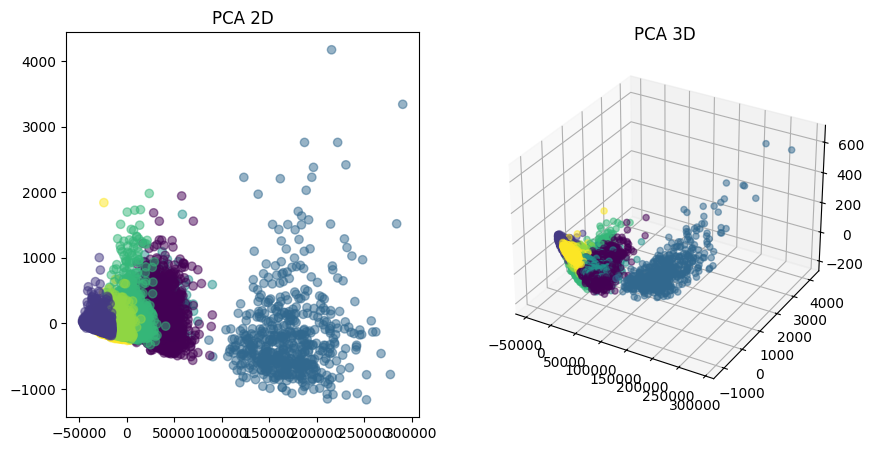

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Giảm chiều về 2D 
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(bean_X)

# Giảm chiều về 3D 
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(bean_X)

# Map các nhãn lớp thành các giá trị số
class_mapping = {'CALI': 0, 'DERMASON': 1, 'BOMBAY': 2, 'BARBUNYA': 3, 'HOROZ': 4, 'SIRA': 5, 'SEKER': 6}
bean_y_classes = bean_y.map(class_mapping)

# Vẽ biểu đồ 2D
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=bean_y_classes, cmap='viridis', alpha=0.5)
plt.title('PCA 2D')
# Vẽ biểu đồ 3D
ax = plt.subplot(1, 2, 2, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=bean_y_classes, cmap='viridis', alpha=0.5)
ax.set_title('PCA 3D')
plt.show()

## Thực hiện MLR, Naive Bayes, ANN trên dữ liệu gốc 

### Phân chia bộ dữ liệu theo tỷ lệ 7:3

In [24]:
# Map các nhãn lớp thành các giá trị số
class_mapping = {'CALI': 0, 'DERMASON': 1, 'BOMBAY': 2, 'BARBUNYA': 3, 'HOROZ': 4, 'SIRA': 5, 'SEKER': 6}
bean_y = bean_y.map(class_mapping)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra theo tỷ lệ 7:3
bean_X_train, bean_X_test, bean_y_train, bean_y_test = train_test_split(bean_X, bean_y, test_size=0.3, random_state=42)

# In số lượng mẫu trong từng tập
print("Số lượng mẫu trong tập huấn luyện:", len(bean_X_train))
print("Số lượng mẫu trong tập kiểm tra:", len(bean_X_test))

Số lượng mẫu trong tập huấn luyện: 9527
Số lượng mẫu trong tập kiểm tra: 4084


### Thực hiện Multinomial Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Khởi tạo mô hình Logistic Regression
mlr_model = LogisticRegression(multi_class='multinomial', max_iter=10000)

# Huấn luyện mô hình trên dữ liệu huấn luyện
mlr_model.fit(bean_X_train, bean_y_train)

LogisticRegression(max_iter=10000, multi_class='multinomial')

In [26]:
# Dự đoán nhãn cho dữ liệu test
mlr_y_pred = mlr_model.predict(bean_X_test)

# Tính toán độ chính xác trên tập test
mlr_accuracy = accuracy_score(bean_y_test, mlr_y_pred)
print("Accuracy on test set for multinomial logistic regression:", mlr_accuracy)

Accuracy on test set for multinomial logistic regression: 0.9113614103819785


### Thực hiện Naive Bayes

In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Khởi tạo mô hình Logistic Regression
nb_model = GaussianNB()

# Huấn luyện mô hình trên dữ liệu huấn luyện
nb_model.fit(bean_X_train, bean_y_train)

GaussianNB()

In [28]:
# Make predictions
nb_y_pred = nb_model.predict(bean_X_test)

# Calculate accuracy
accuracy = accuracy_score(bean_y_test, nb_y_pred)
print("Accuracy on test set for Naive Bayes:", accuracy)

Accuracy on test set for Naive Bayes: 0.7627326150832517


### Thực hiện ANN

In [29]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
train_bean_scaled = scaler.fit_transform(bean_X_train)
test_bean_scaled = scaler.transform(bean_X_test)

# Build the ANN model
ann_model = Sequential()
ann_model.add(Dense(16, activation='relu'))  # input has 16 dimension
ann_model.add(Dense(16, activation='relu'))  # maybe 16 is good
ann_model.add(Dense(7, activation='softmax'))   # output has 7 classes

# Compile the model
ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = ann_model.fit(train_bean_scaled, bean_y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0)
# verbose = 0 to remove cell output as too many output lines
epoch_1_accuracy = history.history['accuracy'][0]
epoch_1_val_accuracy = history.history['val_accuracy'][0]
epoch_100_accuracy = history.history['accuracy'][-1]
epoch_100_val_accuracy = history.history['val_accuracy'][-1]

print("Epoch 1 - Accuracy:", epoch_1_accuracy, "Validation Accuracy:", epoch_1_val_accuracy)
print("Epoch 100 - Accuracy:", epoch_100_accuracy, "Validation Accuracy:", epoch_100_val_accuracy)

Epoch 1 - Accuracy: 0.6198973655700684 Validation Accuracy: 0.8363063931465149
Epoch 100 - Accuracy: 0.9328201413154602 Validation Accuracy: 0.9380902647972107


In [31]:
# Evaluate the model on the test set
ann_test_loss, ann_test_acc = ann_model.evaluate(test_bean_scaled, bean_y_test, verbose=0)
print('Test accuracy of ANN:', ann_test_acc)
print('Test loss of ANN:', ann_test_loss)

Test accuracy of ANN: 0.9314397573471069
Test loss of ANN: 0.19208857417106628


## Thực hiện MLR, Naive Bayes, ANN trên dữ liệu đã giảm chiều về 4

### Thực hiện giảm chiều bean_X_train, bean_X_test về 4

In [32]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Giảm chiều về 2D 
pca_4d = PCA(n_components=4)
bean_X_train = pca_4d.fit_transform(bean_X_train)
bean_X_test = pca_4d.fit_transform(bean_X_test)

### Thực hiện Multinomial Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Khởi tạo mô hình Logistic Regression
mlr_model = LogisticRegression(multi_class='multinomial', max_iter=10000)

# Huấn luyện mô hình trên dữ liệu huấn luyện
mlr_model.fit(bean_X_train, bean_y_train)

/home/harito/venv/py/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=10000, multi_class='multinomial')

In [34]:
# Dự đoán nhãn cho dữ liệu test
mlr_y_pred = mlr_model.predict(bean_X_test)

# Tính toán độ chính xác trên tập test
mlr_accuracy = accuracy_score(bean_y_test, mlr_y_pred)
print("Accuracy on test set for multinomial logistic regression:", mlr_accuracy)

Accuracy on test set for multinomial logistic regression: 0.44833496571988246


### Thực hiện Naive Bayes

In [35]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Khởi tạo mô hình Logistic Regression
nb_model = GaussianNB()

# Huấn luyện mô hình trên dữ liệu huấn luyện
nb_model.fit(bean_X_train, bean_y_train)

GaussianNB()

In [36]:
# Make predictions
nb_y_pred = nb_model.predict(bean_X_test)

# Calculate accuracy
accuracy = accuracy_score(bean_y_test, nb_y_pred)
print("Accuracy on test set for Naive Bayes:", accuracy)

Accuracy on test set for Naive Bayes: 0.4821253672869736


### Thực hiện ANN

In [37]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
train_bean_scaled = scaler.fit_transform(bean_X_train)
test_bean_scaled = scaler.transform(bean_X_test)

# Build the ANN model
ann_model = Sequential()
ann_model.add(Dense(4, activation='relu'))  # input has 4 dimension
ann_model.add(Dense(4, activation='relu'))  # maybe 4 is good
ann_model.add(Dense(7, activation='softmax'))   # output has 7 classes

# Compile the model
ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = ann_model.fit(train_bean_scaled, bean_y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0)
# verbose = 0 to remove cell output as too many output lines
epoch_1_accuracy = history.history['accuracy'][0]
epoch_1_val_accuracy = history.history['val_accuracy'][0]
epoch_100_accuracy = history.history['accuracy'][-1]
epoch_100_val_accuracy = history.history['val_accuracy'][-1]

print("Epoch 1 - Accuracy:", epoch_1_accuracy, "Validation Accuracy:", epoch_1_val_accuracy)
print("Epoch 100 - Accuracy:", epoch_100_accuracy, "Validation Accuracy:", epoch_100_val_accuracy)

Epoch 1 - Accuracy: 0.29577794671058655 Validation Accuracy: 0.44491079449653625
Epoch 100 - Accuracy: 0.9124096035957336 Validation Accuracy: 0.9076600074768066


In [38]:
# Evaluate the model on the test set
ann_test_loss, ann_test_acc = ann_model.evaluate(test_bean_scaled, bean_y_test, verbose=0)
print('Test accuracy of ANN:', ann_test_acc)
print('Test loss of ANN:', ann_test_loss)

Test accuracy of ANN: 0.5002448558807373
Test loss of ANN: 3.219850778579712


## Tổng kết nhận xét 

Với Multinomial Logistic Regression ta có:  
 - 0.9113614103819785 khi giữ nguyên số chiều  
 - 0.44833496571988246 khi giảm số chiều về 4  
Như vậy biến thiên là: 0.463026444662096  
  
Với Naive Bayes ta có:  
 - 0.7627326150832517 khi giữ nguyên số chiều  
 - 0.4821253672869736 khi giảm số chiều về 4  
Như vậy biến thiên là: 0.28060724779627816  
  
Với ANN ta có:  
 - 0.9314397573471069 khi giữ nguyên số chiều  
 - 0.5002448558807373 khi giảm số chiều về 4  
Như vậy biến thiên là: 0.43119490146636963  
  
Và như vậy ta thấy mức độ bị ảnh hưởng khi giảm số chiều về 4 lần lượt là: Multinomial Logistic Regression > ANN > Naive Bayes